In [2]:
import arcgis
import json
import time as tm
import numpy as np
import sqlite3
import logging
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from arcgis.gis import GIS
from arcgis.geometry import Point, Polyline
from arcgis.features import FeatureLayerCollection, FeatureLayer, Feature
from arcgis.mapping import WebMap

In [3]:
def find_project_root(search_filename=".git"):
    """
    Find the root directory of the project by looking for a specific file or directory.

    :param search_filename: The filename or directory to look for to identify the project root.
                            Defaults to '.git'.
    :return: The absolute path to the root directory of the project.
    """
    current_path = Path(__file__).resolve()

    for parent in current_path.parents:
        if (parent / search_filename).exists():
            return parent

    raise FileNotFoundError(f"Could not find the project root containing {search_filename}")

In [4]:
logging.basicConfig(filename='line_matching.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')


class ShortestPath:

    @staticmethod
    def dijkstra(graph: list, start: int, end: int) -> tuple:
        """
        Dijkstra's algorithm for finding the shortest path in a graph.
        :param graph: a graph of nodes in adjacency matrix form
        :param start: source
        :param end: target
        :return: list of shortest distances from node 0 to the last node
        """

        # noinspection PyTypeChecker
        def reconstruct(distances: list, start: int, end: int) -> list:
            """
            Dijkstra helper function. From a given list of shortest connections returns full path.
            :param distances: List of dictionaries containing node number ("node") and list of [from which node,total distance] ("val")
            :param start: source
            :param end: target
            :return: reconstructed path
            """
            path = []
            curr = distances[end]  # set the pointer at the last node of the path
            while str(curr["val"][
                          0]) != '':  # from the last node add the values of "val"[0] key that keep track of the shortest path available.
                path.append(curr["node"])
                curr = distances[curr["val"][0]]
            path.append(start)
            path.reverse()
            return path

        unvisited = set()  # set containing all unvisited nodes
        reachable=[x for x in graph if x.count(0)<len(graph)] # temporary fix
        visited = []
        for j in range(len(graph)):
            unvisited.add(j)
        distances = []
        for i in range(len(graph)):
            if i == start:
                distances.append({"node": i, "val": ['', 0]})
            else:
                distances.append({"node": i, "val": ['',
                                                     'inf']})  # every node as a dictionary with "val" being an array [from which node,total distance]
        current = start
        prev=[]
        while unvisited:  # searching process will continue until it checks all the nodes
            if current not in prev:
                prev.append(current)
            neighbors = [i for i in range(len(graph[current])) if (graph[current][i] != 0 and i in unvisited)]
            for node in neighbors: # consider all neighboring nodes
                dist = distances[node]["val"][1]
                new_dist = distances[current]["val"][1] + graph[current][node]  # calculate the distance from the current node to each neighbor
                if dist == 'inf' or new_dist < dist:  # if the new path is shorter, switch
                    distances[node]["val"][1] = new_dist
                    distances[node]["val"][0] = current
            unvisited.remove(current)  # remove current node from unvisited
            if current not in visited:
                visited.append(current)
            valid = [nodes for nodes in distances if nodes["val"][1] != 'inf' and nodes["node"] in unvisited]  # consider all nodes that connect to current node and are not yet visited
            v = [nodes["val"][1] for nodes in distances if nodes["val"][1] != 'inf' and nodes["node"] in unvisited]  # take their path distances
            if not valid:
                current=visited[visited.index(current)-1]
                unvisited.add(current)
            if not valid and len(visited)==len(reachable):
                break

            for nodes in valid:  # from path distances select the one with the shortest distance
                if nodes["val"][1] == min(v):
                    current = nodes["node"]
        path = reconstruct(distances, start, end)
        length = distances[end]["val"][1]
        return path, length

    def bellman_ford(self, graph: list, start: int, end: int):
        """
        Finds the shortest path between two stops using the Bellman-Ford algorithm.

        Args:
        - start (int): Index of the starting stop.
        - end (int): Index of the ending stop.

        Returns:
        - tuple: A tuple containing the shortest path from the starting stop to the ending stop and the total travel time.
        """
        num_stops = len(graph)
        # Initialize distances from the starting stop to all other stops as infinity
        distances = [float('inf')] * num_stops
        distances[start] = 0

        # Update distances by considering each stop and its neighbors
        for _ in range(num_stops - 1):
            for current_stop in range(num_stops):
                for next_stop in range(num_stops):
                    if graph[current_stop][next_stop] != 0 and distances[current_stop] != float('inf'):
                        if distances[current_stop] + graph[current_stop][next_stop] < distances[next_stop]:
                            distances[next_stop] = distances[current_stop] + graph[current_stop][next_stop]

        # Check for negative cycles
        '''for current_stop in range(num_stops):
            for next_stop in range(num_stops):
                if graph[current_stop][next_stop] != 0 and distances[current_stop] + graph[current_stop][next_stop] < distances[next_stop]:
                    print("The transportation network contains a negative cycle")
                    return [], float('inf')'''

        # Constructing the shortest path from end to start
        path = [end]
        current_stop = end
        length = 0
        while current_stop != start:
            for next_stop in range(num_stops):
                if graph[next_stop][current_stop] != 0 and distances[next_stop] == distances[current_stop] - graph[next_stop][current_stop]:
                    path.insert(0, next_stop)
                    length += graph[next_stop][current_stop]
                    current_stop = next_stop
                    break

        return path, length


    @staticmethod
    def a_star(graph: list, start: int, goal: int) -> tuple:
        """
        A* heuristic algorithm for finding the shortest path in a graph.
        :param graph: a graph of nodes in adjacency matrix form
        :param start: start node
        :param goal: goal node
        :return: tuple
        """

        connection = sqlite3.connect("/Users/dominik/Documents/moje/programowanie/Phyton/Jakniedojade/JakNieDojade/mpk.db")
        cursor = connection.cursor()

        def f_value(node: list) -> float:
            """
            A* Helper function, determining the f_value of the given node.
            :param node: node which f_value will be calculated
            :return: f_value of the given node
            """
            g_value = node[2]
            h_value = np.sqrt((node[3] - x_goal) ** 2 + (node[4] - y_goal) ** 2)
            f_value = g_value + h_value
            return f_value

        def reconstruct_path(closed_list: list, current: list) -> tuple:
            """
            A* helper function to reconstruct the path from start to goal.
            :param closed_list: list of all expanded nodes
            :param current: node whose parent we search for in order to reconstruct the path
            :return: tuple - [0] being the reconstructed path and [1] being the total cost of the path
            """

            path = []
            value = current[2]
            while current is not None:
                path.append(current[1])
                parent = current[0]
                current = next((node for node in closed_list if node[1] == parent), None)
            return path[::-1], value

        open_list = []
        closed_list = []
        x_start = cursor.execute(f"select X from Przystanki where IdP = '{start}';").fetchone()[0]
        y_start = cursor.execute(f"select Y from Przystanki where IdP = '{start}';").fetchone()[0]
        # THE WAY NODES IN OPEN AND CLOSED LISTS ARE STORED: [node's parent, node and node's g value, x coordinate, y coordinate]
        open_list.append([None, start, 0, x_start, y_start])
        x_goal = cursor.execute(f"select X from Przystanki where IdP = '{goal}';").fetchone()[0]
        y_goal = cursor.execute(f"select Y from Przystanki where IdP = '{goal}';").fetchone()[0]

        while len(open_list) != 0:  # executing as long as there are neighbours to nodes

            # determining the neighbour in open_list with the lowest f-value
            lowest_f = f_value(open_list[0])
            current = open_list[0]
            for node in open_list:
                if f_value(node) < lowest_f:
                    lowest_f = f_value(node)
                    current = node

            # checking whether current is goal - returning the path
            if current[1] == goal:
                closed_list.append(current)
                return reconstruct_path(closed_list, current)

            open_list.remove(current)
            closed_list.append(current)
            # for each node in the graph
            for i in range(len(graph[0])):
                # if the node is not the neighbour of current or is already in closed list, skip it
                if graph[current[1]][i] == 0 or any(element[1] == i for element in closed_list):
                    continue
                else:
                    # if the neighbour is already in open list
                    if any(element[1] == i for element in open_list):
                        neighbour_g = current[2] + graph[current[1]][i]
                        for j in range(len(open_list)):
                            if open_list[j][1] == i:
                                # If the new g value is lower than the old g value, update the neighbor’s g value and update its parent to the current node
                                if open_list[j][2] > neighbour_g:
                                    x = cursor.execute(f"select X from Przystanki where IdP = '{j}';").fetchone()[0]
                                    y = cursor.execute(f"select Y from Przystanki where IdP = '{j}';").fetchone()[0]
                                    open_list[j] = [current[1], i, neighbour_g, x, y]

                    # if the neighbour is not in the open list, add it to open list
                    else:
                        neighbour_g = current[2] + graph[current[1]][i]
                        x = cursor.execute(f"select X from Przystanki where IdP = '{i}';").fetchone()[0]
                        y = cursor.execute(f"select Y from Przystanki where IdP = '{i}';").fetchone()[0]
                        open_list.append([current[1], i, neighbour_g, x, y])

        # if the open list is empty and path has not been determined: no path possible, return false
        return ([], )

    def timer(self,graph:list,start:int,end:int)->tuple:
        """
        Returns time of searching the shortest path with Dijkstra's algorithm and Bellman-Ford algorithm.
        """
        start_d = tm.perf_counter_ns()
        self.dijkstra(graph,start,end)
        end_d = tm.perf_counter_ns()

        start_bf = tm.perf_counter_ns()
        self.bellman_ford(graph,start,end)
        end_bf = tm.perf_counter_ns()

        return end_d-start_d, end_bf-start_bf

    def match_lines_to_path(self, path: list, lines: list) -> list:
        """
        Matches public transportation lines to a path.
        :param path: a path represented by a list with numbers of nodes in a graph.
        :param lines: a list of public transportation lines represented by dictionaries.
        :returns: returns a list of tuples [(stops, line)]
        """

        def find_matching_subsequence(list1, list2) -> list:
            """
            Helper function for finding a subsequence starting in the first node of list1
            """
            first_element = list1[0]
            list2 = list(dict.fromkeys(list2))  # remove duplicates from the list to prevent bugs

            # Check if there are no subsequences
            try:
                start_index = list2.index(first_element)
            except ValueError:
                return []

            # Check if list1 is a subsequence starting from this index in list2
            if list2[start_index:start_index + len(list1)] == list1:
                return list2[start_index:start_index + len(list1)]

            longest_subsequence = []
            for i in range(len(list1)):
                # Check for the longest subsequence if starting index is in list2
                if start_index + i < len(list2) and list1[i] == list2[start_index + i]:
                    longest_subsequence.append(list1[i])
                else:
                    break

            return longest_subsequence

        route = []
        path_temp = path.copy()

        logging.info(f"Starting match_lines_to_path with path: {path}")

        # Loop over path removing stops
        while len(path_temp) > 0:
            longest_overlap = []
            longest_line = ''
            for line in lines:
                stops = line[0]["Przystanki"]
                overlap = find_matching_subsequence(path_temp, stops)  # Find current overlap using helper function

                # Check for overlaps in reversed line stops
                stops.reverse()
                overlap_reversed = find_matching_subsequence(path_temp, stops)
                stops.reverse()

                # Swap for reversed version if it's longer
                if len(overlap) < len(overlap_reversed):
                    overlap = overlap_reversed

                # Check if current overlap is longer than the previous one, promote trams as they are usually preferred by the people
                if len(overlap) > len(longest_overlap) or (line[0]["Nazwa"] in ['Tramwaj_na_Maslice', 'Tramwaj_na_Swojczyce', 'Tramwaj_Borowska_Szpital', 'Tramwaj_na_Klecine', 'Tramwaj_na_Jagodno', 'Tramwaj_na_Ołtaszyn', 'Tramwaj_na_Gajowice', 'Tramwaj_na_Gądów','Tramwaj_na_Psie_Pole'] and len(overlap)==len(longest_overlap)):
                    longest_overlap = overlap
                    longest_line = line[0]["Nazwa"]

            logging.info(f"Current longest_overlap: {longest_overlap} with line: {longest_line}")

            if longest_overlap:
                name = longest_overlap  # Initialize name for dictionary (it can't store lists as key)
                route.append((name, longest_line))  # Add info to dictionary

                # Remove current longest overlap from path
                if len(longest_overlap) > 2:
                    path_temp = path_temp[
                                len(longest_overlap) - 1:]  # Update path_temp correctly, preserving the last element
                else:
                    path_temp = path_temp[1:]  # Update path_temp correctly

                logging.info(f"Updated path_temp: {path_temp}")
            else:
                break

            # Check if path has 1 element, which means we have finished matching lines, thus remove the last element
            if len(path_temp) == 1:
                path_temp.pop()

        logging.info(f"Final route: {route}")

        return route

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import sqlite3
# from Algorithms import ShortestPath
# from Database.FindProject import find_project_root
from arcgis.geometry import Point, Polyline

class Visualizer:
    def __init__(self):
        project_root = find_project_root()
        self.db = sqlite3.connect(project_root / 'mpk.db')
        self.cursor = self.db.cursor()

    def get_nodes_from_graph(self, graph: list, path = []) -> tuple:
        """
        Converts a graph in adjacency matrix form into a collection of connections between nodes.
        :param graph: a graph in adjacency matrix form.
        :param start: node IDs for showing the shortest path between them on the graph.
        :param end: node IDs for showing the shortest path between them on the graph.
        :returns: returns (all connections, connections in the shortest path between stops given).
        """
        sp = ShortestPath()
        connections = []
        nodes_in_path = []

        if path:
            for i in range(len(path) - 1):
                nodes_in_path.append((path[i], path[i + 1]))  # add adjacent nodes from the path extracted by the algorithm to the graphs nodes

        else:
            path = []

        for j in range(len(graph)):
            for k in range(len(graph)):
                if j != k:
                    if graph[j][k] != 0:
                        connections.append((j, k))  # append connections between two nodes represented by j,k
        return connections, nodes_in_path

    def get_node_sizes(self, graph: list) -> dict:
        """
        Adjusts node sizes in a graph based on the number of possible destinations from the stop that the node represents.
        :param graph: a graph in adjacency matrix form.
        :returns: returns a dictionary of node sizes corresponding to every node index.
        """
        node_sizes = {}
        for j in range(len(graph)):
            counter = 0  # count the amount of connections from every node
            for k in range(len(graph)):
                if j != k and graph[j][k] != 0:
                    counter += 1
            if counter >= 5:  # for big nodes
                node_sizes[j] = counter * 15
            else:  # for small nodes
                node_sizes[j] = 8  # possible change
        return node_sizes

    def get_vertice_styles(self, networkx_graph: nx.Graph, connections_in_path: list) -> tuple:
        """
        Adjusts styling of networkx graph vertices for path vertices and other vertices.
        :param networkx_graph: a networkx graph class with already existing edges.
        :param connections_in_path: edges belonging to the shortest path between two nodes calculated in get_nodes_from_graph method.
        :returns: a tuple of dictionaries with vertice colors and widths
        """
        vertice_colors = {}
        vertice_width = {}

        for edge in networkx_graph.edges:
            # check if edge is in path
            # networkx doesn't allow duplicates thus also check for revers node IDs in an edge.
            if edge in connections_in_path or (edge[1], edge[0]) in connections_in_path:
                vertice_colors[edge] = 'purple'  # possible changes here
                vertice_width[edge] = 4  # possible changes here
            else:
                vertice_colors[edge] = 'pink'  # possible changes here
                vertice_width[edge] = 2  # possible changes here
        return vertice_colors, vertice_width

    def get_pos(self, networkx_graph: nx.Graph) -> dict:
        """
        For each node gets its coordinates from the database.
        :param networkx_graph: a networkx graph class with already existing nodes.
        :returns: a dictionary with every node's coordinates.
        """
        pos = {}
        for node in networkx_graph.nodes:
            coordinates = self.cursor.execute(f"SELECT Y,X FROM Nowe_przystanki WHERE IdP = '{node}'").fetchone()  # get nodes coordinates from the db
            pos[node] = coordinates
        return pos

    def get_labels(self, networkx_graph: nx.Graph, node_sizes: dict) -> dict:
        """
        For each node determine displayed label.
        :param networkx_graph: a networkx graph class with already existing nodes.
        :param node_sizes: a dictionary where each node ID has size assigned.
        :returns: a dictionary with custom labels for each node.
        """
        labels = {}
        for node in networkx_graph.nodes:
            if node_sizes[node] >= 75:  # check if node has more than 5 connection, terrible design needs changed
                name = self.cursor.execute(f"SELECT Nazwa FROM Nowe_przystanki WHERE IdP = '{node}'").fetchone()  # get stop's name from the db
                labels[node] = name[0]
            else:
                labels[node] = ''  # for small stops do not display any label
        return labels

    def draw_graph(self, graph: list,filename: str, path = []):  # mozna zmienic to zeby bralo start i end losowo, wtedy mozna dowolna trase zaznaczyc
        """
        Draws a graph in an adjacency matrix form.
        """
        connections, connections_in_path = self.get_nodes_from_graph(graph, path)  # possible change for simulation purposes
        node_sizes = self.get_node_sizes(graph)

        G = nx.Graph()
        G.add_edges_from(connections)

        vertice_colors, vertice_width = self.get_vertice_styles(G, connections_in_path)

        pos = self.get_pos(G)
        sizes = [node_sizes[node] for node in G.nodes]
        colors = [vertice_colors[edge] for edge in G.edges()]
        widths = [vertice_width[edge] for edge in G.edges()]
        labels = self.get_labels(G, node_sizes)

        plt.figure(figsize=(20, 20))
        nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='grey')
        nx.draw_networkx_edges(G, pos, edge_color=colors, width=widths)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='black', font_weight='bold',
                                verticalalignment='center', horizontalalignment='left',
                                bbox=dict(facecolor='white', alpha=0.4, edgecolor='none',
                                          boxstyle='round,pad=0.2'))
        plt.savefig(filename)
        plt.close()

    def map_stops(self,map):
        yx_all = self.cursor.execute("SELECT Nazwa,Y,X FROM Nowe_przystanki").fetchall()
        for yx in yx_all:
            point = Point({'x': yx[1], 'y': yx[2]})

            simple_marker_symbol = {
                "type": "esriSMS",
                "style": "esriSMSCircle",
                "color": [0, 0, 0],  # zmienic kolory tutaj
                "outline": {"color": [255, 255, 255], "width": 1},
            }

            point_attributes = {"name": yx[0],
                                "description": "I am a point"}  # jakis pomysl na description by sie przydal

            map.draw(
                shape=point,
                symbol=simple_marker_symbol,
                attributes=point_attributes,
                popup={
                    "title": point_attributes["name"],
                    "content": point_attributes["description"],
                },
            )

    def map_path(self,map, graph, lines, start, end,version):
        sp = ShortestPath()
        p = sp.dijkstra(graph, start, end)[0]
        print(sp.dijkstra(graph, start, end)[1])
        pt_route = sp.match_lines_to_path(p, lines)
        print(pt_route)
        i = 0
        paths = []
        path_temp = []
        color_codes = [
            [255, 0, 0],  # Red
            [0, 255, 0],  # Green
            [0, 0, 255],  # Blue
            [255, 255, 0],  # Yellow
            [0, 255, 255],  # Cyan
            [255, 0, 255],  # Magenta
            [192, 192, 192],  # Silver
            [128, 128, 128],  # Gray
            [128, 0, 0],  # Maroon
            [128, 128, 0],  # Olive
            [0, 128, 0],  # Dark Green
            [128, 0, 128],  # Purple
            [0, 128, 128],  # Teal
            [0, 0, 128],  # Navy
            [255, 165, 0],  # Orange
            [255, 192, 203],  # Pink
            [165, 42, 42],  # Brown
            [75, 0, 130],  # Indigo
            [255, 20, 147],  # Deep Pink
            [173, 216, 230]  # Light Blue
        ]
        for line in pt_route:
            path_temp = line[0]

            path = []
            stop_names = []
            for stops in path_temp:
                name = self.cursor.execute(f"SELECT Nazwa FROM Nowe_przystanki WHERE Idp = '{stops}'").fetchone()[0]
                yx = self.cursor.execute(f"SELECT Y,X FROM Nowe_przystanki WHERE Idp = '{stops}'").fetchone()
                path.append([yx[0], yx[1]])
                stop_names.append(name)
            stop_names.reverse()
            polyline = Polyline(
                {
                    "paths": path
                }
            )

            polyline_attributes = {"name": line[1], "description": ", ".join(
                stop_names)+f"\n{version}"}  # zmienić na nazwy linii, opcjonalnie każdy fragment inną linią zaznaczyć innym kolorem

            simple_line_symbol = {
                "type": "esriSLS",
                "style": "esriSLSolid",
                "color": color_codes[i],
                "width": 2,
            }

            map.draw(
                shape=polyline,
                symbol=simple_line_symbol,
                attributes=polyline_attributes,
                popup={
                    "title": polyline_attributes["name"],
                    "content": polyline_attributes["description"],
                },
            )
            i += 1


'''v = Visualizer()
file = open("C:\\Users\\paula\\PycharmProjects\\JakNieDojade\\Dane\\graph.json", "r")
graph = json.load(file)
v.draw_graph(graph,10,908)'''

'v = Visualizer()\nfile = open("C:\\Users\\paula\\PycharmProjects\\JakNieDojade\\Dane\\graph.json", "r")\ngraph = json.load(file)\nv.draw_graph(graph,10,908)'

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


class Results:
    def __init__(self):
        # initialize arrays for each size
        self.under_five = []
        self.five_ten = []
        self.ten_fifteen = []
        self.fifteen_twenty = []
        self.over_twenty = []
        self.num_under_five = 0
        self.num_five_ten = 0
        self.num_ten_fifteen = 0
        self.num_fifteen_twenty = 0
        self.num_over_twenty = 0

    def calculate_statistics(self):
        means = [np.mean(self.under_five),np.mean(self.five_ten),np.mean(self.ten_fifteen),np.mean(self.fifteen_twenty),np.mean(self.over_twenty)]
        sds = [np.std(self.under_five),np.std(self.five_ten),np.std(self.ten_fifteen),np.std(self.fifteen_twenty),np.std(self.over_twenty)]
        minimums = [min(self.under_five),min(self.five_ten),min(self.ten_fifteen),min(self.fifteen_twenty),min(self.over_twenty)]
        maximums = [max(self.under_five),max(self.five_ten),max(self.ten_fifteen),max(self.fifteen_twenty),max(self.over_twenty)]

        return means, sds, minimums, maximums

    def draw_boxplot(self, title):
        # Prepare data for seaborn
        data = {
            '< 5': self.under_five,
            '5-10': self.five_ten,
            '10-15': self.ten_fifteen,
            '15-20': self.fifteen_twenty,
            '> 20': self.over_twenty
        }

        # Convert data to long-form DataFrame for seaborn
        import pandas as pd
        df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))

        # Melt DataFrame to long-form
        df_melted = df.melt(var_name='Distance', value_name='Time')

        # Create the boxplot
        plt.figure(figsize=(10, 7))
        sns.boxplot(x='Distance', y='Time', data=df_melted)
        plt.title(title)
        plt.show()



In [17]:
con = sqlite3.connect('D:\PyCharm\PyCharm 2023.2.4\JakNieDojade\mpk.db')
cursor = con.cursor()

In [18]:
file = open('D:\\PyCharm\\PyCharm 2023.2.4\\JakNieDojade\\Dane\\graph.json', 'r')
graph = json.load(file)

file1 = open('D:\\PyCharm\\PyCharm 2023.2.4\\JakNieDojade\\Dane\\test2.json', 'r')
lines = json.load(file1)

In [7]:
gis = GIS(api_key = 'AAPK32cfafb36cf845faabb512edf3385129OaqTvR2s5ASHCY-SAga4AWxlU94IqARqp-qIHkwqpisyy2PSWpkouNvwTO3a134W')
map = gis.map()
map

MapView(layout=Layout(height='400px', width='100%'))

In [25]:
def draw_path(graph,start,end,version):
    sp = ShortestPath()
    p = sp.dijkstra(graph,start,end)[0]
    print(sp.dijkstra(graph,start,end)[1])
    pt_route = sp.match_lines_to_path(p,lines)
    print(pt_route)
    i = 0
    paths = []
    path_temp = []
    color_codes = [
    [255, 0, 0],      # Red
    [0, 255, 0],      # Green
    [0, 0, 255],      # Blue
    [255, 255, 0],    # Yellow
    [0, 255, 255],    # Cyan
    [255, 0, 255],    # Magenta
    [192, 192, 192],  # Silver
    [128, 128, 128],  # Gray
    [128, 0, 0],      # Maroon
    [128, 128, 0],    # Olive
    [0, 128, 0],      # Dark Green
    [128, 0, 128],    # Purple
    [0, 128, 128],    # Teal
    [0, 0, 128],      # Navy
    [255, 165, 0],    # Orange
    [255, 192, 203],  # Pink
    [165, 42, 42],    # Brown
    [75, 0, 130],     # Indigo
    [255, 20, 147],   # Deep Pink
    [173, 216, 230]   # Light Blue
]
    for line in pt_route:
        path_temp = line[0]
        
        path = []
        stop_names = []
        for stops in path_temp:
            name = cursor.execute(f"SELECT Nazwa FROM Przystanki WHERE Idp = '{stops}'").fetchone()[0]
            yx = cursor.execute(f"SELECT Y,X FROM Przystanki WHERE Idp = '{stops}'").fetchone()
            path.append([yx[0],yx[1]])
            stop_names.append(name)
        stop_names.reverse()
        polyline = Polyline(
            {
                "paths": path
            }
        )

        polyline_attributes = {"name": line[1], "description": ", ".join(stop_names) +f'\n{version}'} # zmienić na nazwy linii, opcjonalnie każdy fragment inną linią zaznaczyć innym kolorem 

        simple_line_symbol = {
            "type": "esriSLS",
            "style": "esriSLSolid",
            "color": color_codes[i],
            "width": 2,
        }

        map.draw(
            shape=polyline,
            symbol=simple_line_symbol,
            attributes=polyline_attributes,
            popup={
                "title": polyline_attributes["name"],
                "content": polyline_attributes["description"],
            },
        )
        i += 1

In [21]:
def map_stops():
    yx_all = self.cursor.execute("SELECT Nazwa,Y,X FROM Nowe_przystanki").fetchall()
    for yx in yx_all:
        point = Point({'x':yx[1],'y':yx[2]})
        
        simple_marker_symbol = {
            "type": "esriSMS",
            "style": "esriSMSCircle",
            "color": [0, 0, 0], # zmienic kolory tutaj
            "outline": {"color": [255, 255, 255], "width": 1},
        }
        
        point_attributes = {"name": yx[0], "description": "I am a point"}  # jakis pomysl na description by sie przydal
        
        map.draw(
            shape=point,
            symbol=simple_marker_symbol,
            attributes=point_attributes,
            popup={
                "title": point_attributes["name"],
                "content": point_attributes["description"],
            },
        )
map_stops()

In [26]:
draw_path(graph,21,22)

41
[([21, 50, 48, 49, 125, 531, 595, 593], 'Linia_904'), ([593, 88, 376, 833, 884, 319], 'Linia_D'), ([319, 796, 428, 209, 749, 108], 'Linia_345'), ([108, 39, 438, 11], 'Linia_143'), ([11, 542, 289, 776, 748, 26, 109, 25, 853, 7, 22], 'Linia_114')]


In [27]:
draw_path(graph,333,777)

35
[([333, 188, 4, 180, 743, 519, 426, 31, 543, 118, 377], 'Linia_10'), ([377, 774, 431, 467, 485, 484, 664, 468, 33], 'Linia_129'), ([33, 286], 'Linia_319'), ([286, 382, 805, 527, 898, 392, 643, 331, 777], 'Linia_908')]


In [28]:
map.clear_graphics()

C:\Users\miki\AppData\Local\Temp\ipykernel_17808\3578304147.py:128: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=colors, width=widths)


51
[([417, 208, 775, 112, 253, 69], 'Linia_123'), ([69, 340, 599, 425, 423, 652, 424, 739, 139, 200, 446, 322, 774], 'Linia_103_1'), ([774, 431, 467, 485, 484, 664, 468, 33, 70], 'Linia_129'), ([70, 573, 715, 291], 'Linia_105'), ([291, 35, 266], 'Linia_116'), ([266, 351, 194, 88, 593, 595], 'Linia_N')]
18
[([417, 420, 61, 418, 213, 575, 804, 886], 'Linia_123'), ([886, 393, 452], 'Linia_938'), ([452, 367], 'Linia_138'), ([367, 936, 88, 104, 852, 593, 595], 'Tramwaj_na_Psie_Pole')]
41
[([602, 291, 715, 573, 70, 33], 'Linia_105'), ([33, 468, 664, 484, 485, 467, 431, 774], 'Linia_129'), ([774, 322, 446, 200, 139, 739, 424, 652, 423, 425, 599, 340, 69, 253, 112, 775, 208], 'Linia_103_1'), ([208, 417, 420, 61, 418], 'Linia_123')]
18
[([602, 35, 266, 351, 194, 88], 'Linia_130'), ([88, 936, 367], 'Tramwaj_na_Psie_Pole'), ([367, 452], 'Linia_138'), ([452, 393, 886], 'Linia_938'), ([886, 804, 575, 213, 418], 'Linia_123')]
48
[([520, 637, 292, 491, 601], 'Linia_111'), ([601, 138, 576, 381, 427, 8

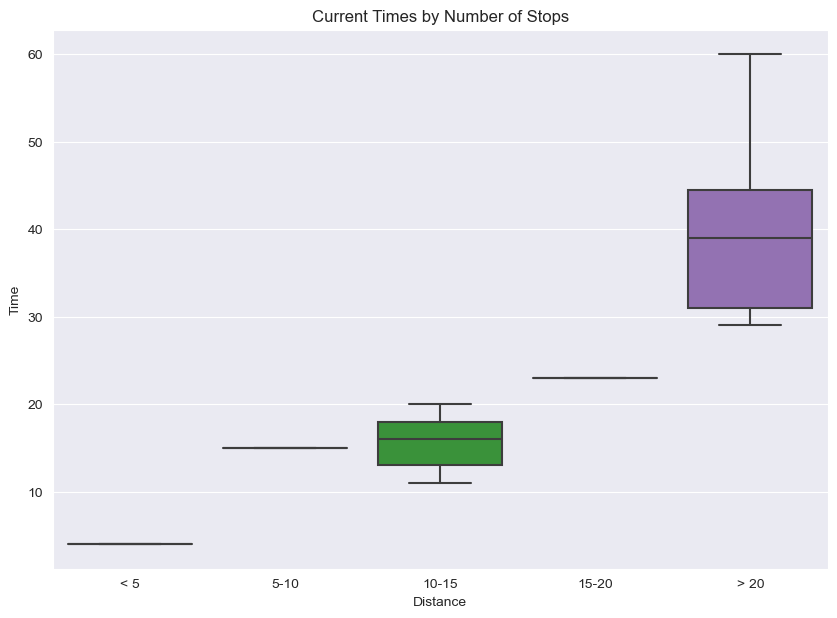

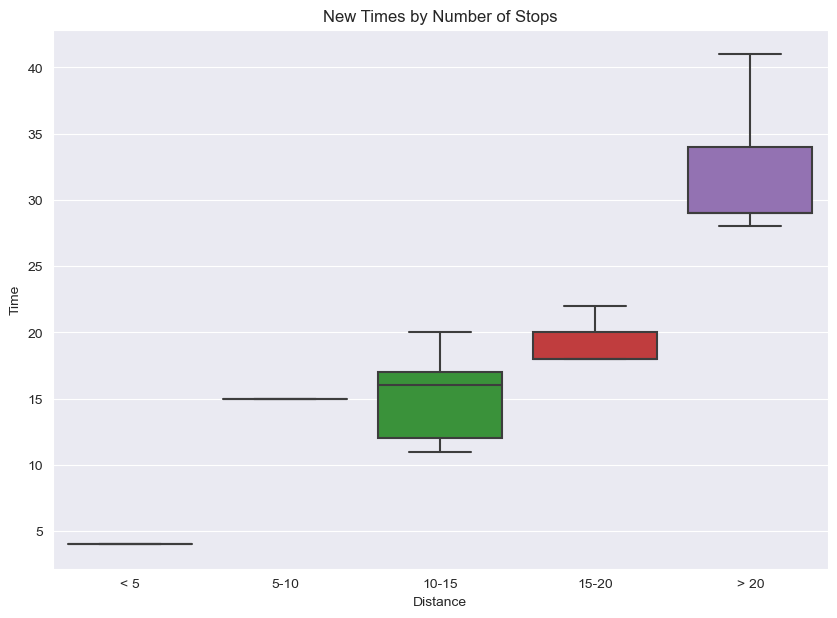

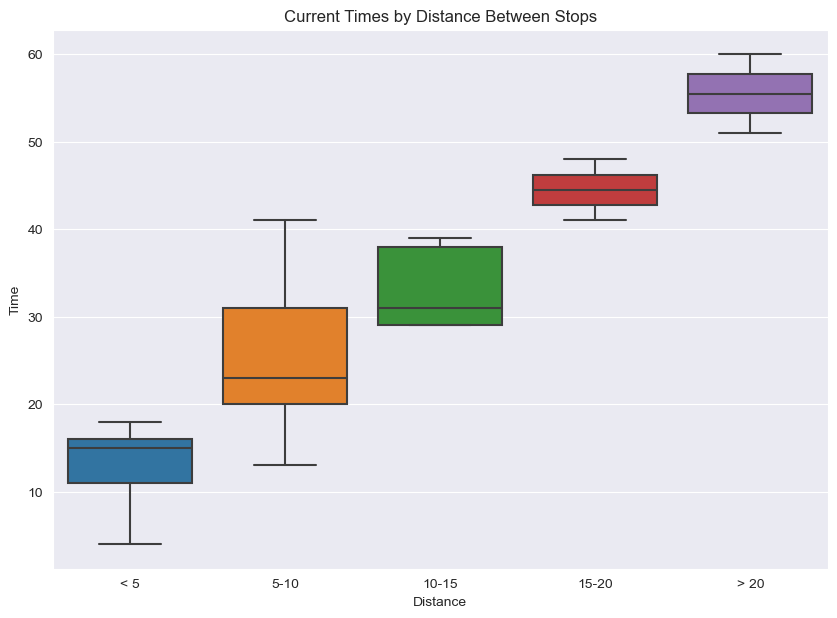

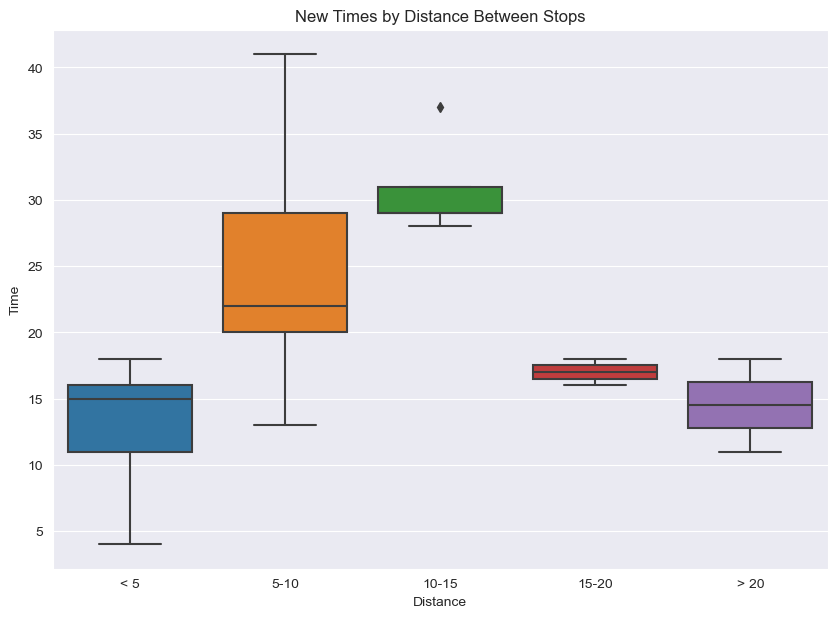

{'Tramwaj_na_Maslice': 0, 'Tramwaj_na_Swojczyce': 0, 'Tramwaj_Borowska_Szpital': 0, 'Tramwaj_na_Klecine': 0, 'Tramwaj_na_Jagodno': 0, 'Tramwaj_na_Ołtaszyn': 0, 'Tramwaj_na_Gajowice': 0, 'Tramwaj_na_Gądów': 0}
150
{'Linia_1': 1, 'Linia_10': 1, 'Linia_100': 1, 'Linia_101': 2, 'Linia_102': 2, 'Linia_103': 3, 'Linia_103_1': 1, 'Linia_104': 1, 'Linia_105': 0, 'Linia_106': 0, 'Linia_107': 1, 'Linia_108': 1, 'Linia_11': 2, 'Linia_110': 1, 'Linia_110_1': 0, 'Linia_111': 3, 'Linia_112': 1, 'Linia_113': 0, 'Linia_114': 0, 'Linia_115': 0, 'Linia_116': 1, 'Linia_117': 0, 'Linia_118': 0, 'Linia_119': 1, 'Linia_119_1': 1, 'Linia_12': 1, 'Linia_120': 0, 'Linia_120_1': 0, 'Linia_121': 0, 'Linia_122': 1, 'Linia_123': 4, 'Linia_124': 1, 'Linia_124_1': 0, 'Linia_125': 0, 'Linia_126': 2, 'Linia_127': 2, 'Linia_127_1': 1, 'Linia_128': 3, 'Linia_129': 1, 'Linia_12_1': 0, 'Linia_13': 0, 'Linia_130': 2, 'Linia_131': 0, 'Linia_132': 1, 'Linia_133': 0, 'Linia_133_1': 0, 'Linia_133_2': 0, 'Linia_133_3': 0, 'Lini

In [12]:
import time 
import json
import sqlite3
import random
import math

from Database.FindProject import find_project_root

# get project root
project_root = find_project_root()

# import a graph with current stops
file = open(project_root / 'Dane' / 'graph.json','r')
current_graph = json.load(file)

# import a graph with projected changes in public transportation infrastructure
file = open(project_root / 'Dane' / 'new_graph.json','r')
new_graph = json.load(file)

# import all public transportation lines
file = open(project_root / 'Dane' / 'nowe_linie1.json','r',encoding='UTF-8')
all_lines = json.load(file)
all_lines_count = {line[0]["Nazwa"]:0 for line in all_lines}
file = open(project_root / 'Dane' / 'test2.json','r',encoding='UTF-8')
cur_lines = json.load(file)
# import new public transportation lines
file = open(project_root / 'Dane' / 'nowe_linie.json','r',encoding='UTF-8')
lines_file = json.load(file)
new_lines = []
for lines in lines_file:
    new_lines.append(lines[0]["Nazwa"])

# initialize pathfinding modules
sp = ShortestPath()
vis = Visualizer()

# initialize DB connection
db = sqlite3.connect(project_root / 'mpk.db')
cursor = db.cursor()

# create probability list from percentages in database
current_stops_info = cursor.execute("SELECT IdP,Nazwa,Percentage FROM Przystanki_percentages").fetchall()
new_stops_info = cursor.execute("SELECT IdP,Nazwa,Percentage FROM Nowe_przystanki_percentages").fetchall()

current_stops_ids = []
stop_ids = []
weights = []
for stop in current_stops_info:
    current_stops_ids.append(stop[0])
for stop in new_stops_info:
    weights.append(stop[2])
    stop_ids.append(stop[0])

# initialize time counters
current_times_stops = Results()
new_times_stops = Results()
current_times_dist = Results()
new_times_dist = Results()

# initialize other counters
total_new_lines_use = 0
total_time_saved = 0
new_paths = 0
new_lines_count = {'Tramwaj_na_Maslice':0,'Tramwaj_na_Swojczyce':0,'Tramwaj_Borowska_Szpital':0,'Tramwaj_na_Klecine':0,'Tramwaj_na_Jagodno':0, 'Tramwaj_na_Ołtaszyn':0, 'Tramwaj_na_Gajowice':0, 'Tramwaj_na_Gądów':0}

# start Monte Carlo simulation
for i in range(20):
    start,end = random.choices(stop_ids,weights,k=2)

    if start not in current_stops_ids or end not in current_stops_ids:
        new_paths += 1
        path_new, time_new = sp.dijkstra(new_graph, start, end)

        pt_route = sp.match_lines_to_path(path_new, all_lines)

        for r in pt_route:
            if r[1] in new_lines:
                total_new_lines_use += 1
            all_lines_count[r[1]] += 1
        vis.draw_graph(new_graph, f"new {i}.png", path_new)
        #vis.map_stops(map)
        vis.map_path(map,new_graph,all_lines,start,end,'new')
        time.sleep(30)
        map.clear_graphics()
        continue

    path_cur,time_cur = sp.dijkstra(current_graph,start,end)
    path_new,time_new = sp.dijkstra(new_graph,start,end)

    pt_route = sp.match_lines_to_path(path_new,all_lines)

    # check if route includes new public transportation lines
    for r in pt_route:
        if r[1] in new_lines:
            total_new_lines_use += 1
            total_time_saved += time_cur - time_new
            vis.draw_graph(current_graph, f"cur {i}.png", path_cur)
            vis.draw_graph(new_graph, f"new {i}.png", path_new)
            #vis.map_stops(map)
            vis.map_path(map,current_graph,cur_lines,start,end,'cur')
            vis.map_path(map,new_graph,all_lines,start,end,'new')
            time.sleep(13)
            map.clear_graphics()
        # count every use of each line
        all_lines_count[r[1]] += 1

    # check distance between stops
    x1,y1 = cursor.execute(f"SELECT X,Y FROM Nowe_przystanki WHERE IdP = '{start}';").fetchone()
    #print(x1,y1)
    x2,y2 = cursor.execute(f"SELECT X,Y FROM Nowe_przystanki WHERE IdP = '{end}';").fetchone()
    #print(x2,y2)
    dist = (math.sqrt((pow(x1-x2,2)+pow(y1-y2,2))))*100
    #print(dist)

    # check number of stops in paths
    num_stops_cur = len(path_cur)
    num_stops_new = len(path_new)

    # check the distance between stops
    if dist < 5:
        current_times_dist.under_five.append(time_cur)
        current_times_dist.num_under_five += 1
        new_times_dist.under_five.append(time_new)
        new_times_dist.num_under_five += 1
    elif 5 <= dist < 10:
        current_times_dist.five_ten.append(time_cur)
        current_times_dist.num_five_ten += 1
        new_times_dist.five_ten.append(time_new)
        new_times_dist.num_five_ten += 1
    elif 10 <= dist < 15:
        current_times_dist.ten_fifteen.append(time_cur)
        current_times_dist.num_ten_fifteen += 1
        new_times_dist.ten_fifteen.append(time_new)
        new_times_dist.num_ten_fifteen += 1
    elif 15 <= dist < 20:
        current_times_dist.fifteen_twenty.append(time_cur)
        current_times_dist.num_fifteen_twenty += 1
        new_times_dist.fifteen_twenty.append(time_new)
        new_times_dist.num_fifteen_twenty += 1
    else:
        current_times_dist.over_twenty.append(time_cur)
        current_times_dist.num_over_twenty += 1
        new_times_dist.over_twenty.append(time_new)
        new_times_dist.num_over_twenty += 1

    if num_stops_cur < 5:
        current_times_stops.under_five.append(time_cur)
        current_times_stops.num_under_five += 1
    elif 5 <= num_stops_cur < 10:
        current_times_stops.five_ten.append(time_cur)
        current_times_stops.num_five_ten += 1
    elif 10 <= num_stops_cur < 15:
        current_times_stops.ten_fifteen.append(time_cur)
        current_times_stops.num_ten_fifteen += 1
    elif 15 <= num_stops_cur < 20:
        current_times_stops.fifteen_twenty.append(time_cur)
        current_times_stops.num_fifteen_twenty += 1
    else:
        current_times_stops.over_twenty.append(time_cur)
        current_times_stops.num_over_twenty += 1

    if num_stops_new < 5:
        new_times_stops.under_five.append(time_new)
        new_times_stops.num_under_five += 1
    elif 5 <= num_stops_new < 10:
        new_times_stops.five_ten.append(time_new)
        new_times_stops.num_five_ten += 1
    elif 10 <= num_stops_new < 15:
        new_times_stops.ten_fifteen.append(time_new)
        new_times_stops.num_ten_fifteen += 1
    elif 15 <= num_stops_new < 20:
        new_times_stops.fifteen_twenty.append(time_new)
        new_times_stops.num_fifteen_twenty += 1
    else:
        new_times_stops.over_twenty.append(time_new)
        new_times_stops.num_over_twenty += 1


current_times_stops.draw_boxplot("Current Times by Number of Stops")
new_times_stops.draw_boxplot("New Times by Number of Stops")
current_times_dist.draw_boxplot("Current Times by Distance Between Stops")
new_times_dist.draw_boxplot("New Times by Distance Between Stops")
print(new_lines_count)
print(total_time_saved)
print(all_lines_count)